<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [54]:
# Set your student number
student_number = 400101175
Name = 'Mohammad Armin'
Last_Name = 'Dehghan'

In [55]:
from google.colab import files
uploaded = files.upload()

Saving ae_helper.py to ae_helper (1).py


In [56]:
!ls

'ae_helper (1).py'   ae_helper.py   model_checkpoints   __pycache__   sample_data


# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

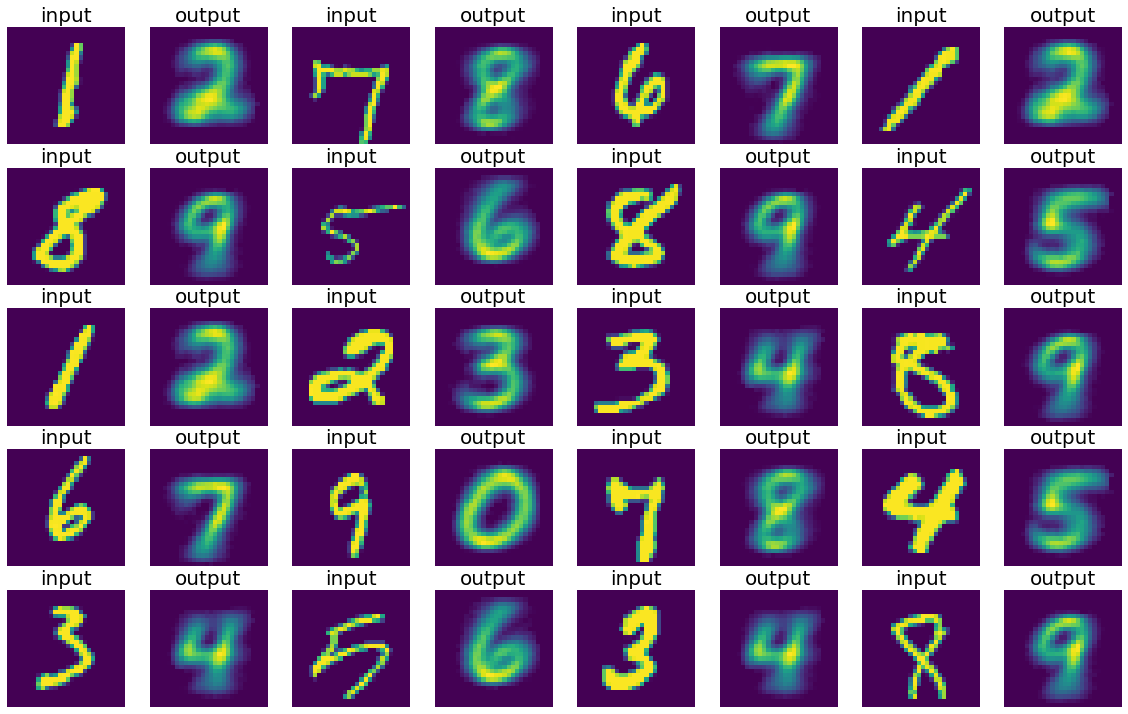

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [57]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Here


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [66]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28 , 512 ),
            nn.ReLU(),
            nn.Linear(512 , 128 ),
            nn.ReLU(),
            nn.Linear(128 , 64 ),
            nn.ReLU(),
            nn.Linear(64 , 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32 , 64 ),
            nn.ReLU(),
            nn.Linear(64 , 128 ),
            nn.ReLU(),
            nn.Linear(128 , 512 ),
            nn.ReLU(),
            nn.Linear(512 , 28*28 ),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [67]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [68]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [69]:
# place for your custom functions for training and evaluation of the autoencoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:

    for (digit , next_digit , lable) in dataloader :
      epoch_loss = 0

      digit = digit.to(device).view(-1, 784)
      next_digit = next_digit.to(device).view(-1, 784)

      recon = model(digit)
      loss = nn.MSELoss()(recon, next_digit)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    return epoch_loss/len(dataloader)


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    epoch_loss = 0

    with torch.no_grad():
        for (img, target, _) in dataloader:
            img, target = img.to(device).view(-1, 784), target.to(device).view(-1, 784)
            output = model(img)
            loss = nn.MSELoss()(output, target)
            epoch_loss += loss.item()

    return epoch_loss/len(dataloader)



## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [70]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, weight_decay=1e-5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [71]:
import os

#### TRAINING AND VALIDATION LOOP ####

# Number of epochs
num_epochs = 20

best_val_loss = float('inf')
best_model_wts = None

for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = ae.state_dict()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

if best_model_wts is not None:
    os.makedirs('model_checkpoints', exist_ok=True)
    torch.save(best_model_wts, 'model_checkpoints/best_autoencoder.pth')
    print(f'Best model saved with validation loss: {best_val_loss:.4f}')

Epoch [1/20], Train Loss: 0.0007, Val Loss: 0.0667
Epoch [2/20], Train Loss: 0.0006, Val Loss: 0.0636
Epoch [3/20], Train Loss: 0.0006, Val Loss: 0.0606
Epoch [4/20], Train Loss: 0.0006, Val Loss: 0.0592
Epoch [5/20], Train Loss: 0.0006, Val Loss: 0.0580
Epoch [6/20], Train Loss: 0.0006, Val Loss: 0.0569
Epoch [7/20], Train Loss: 0.0005, Val Loss: 0.0561
Epoch [8/20], Train Loss: 0.0006, Val Loss: 0.0559
Epoch [9/20], Train Loss: 0.0006, Val Loss: 0.0556
Epoch [10/20], Train Loss: 0.0006, Val Loss: 0.0554
Epoch [11/20], Train Loss: 0.0006, Val Loss: 0.0555
Epoch [12/20], Train Loss: 0.0006, Val Loss: 0.0553
Epoch [13/20], Train Loss: 0.0006, Val Loss: 0.0553
Epoch [14/20], Train Loss: 0.0005, Val Loss: 0.0554
Epoch [15/20], Train Loss: 0.0006, Val Loss: 0.0553
Epoch [16/20], Train Loss: 0.0005, Val Loss: 0.0553
Epoch [17/20], Train Loss: 0.0005, Val Loss: 0.0552
Epoch [18/20], Train Loss: 0.0006, Val Loss: 0.0553
Epoch [19/20], Train Loss: 0.0005, Val Loss: 0.0552
Epoch [20/20], Train 

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [73]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
best_model_path = 'model_checkpoints/best_autoencoder.pth'

# Load the state dictionary into the model
ae.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

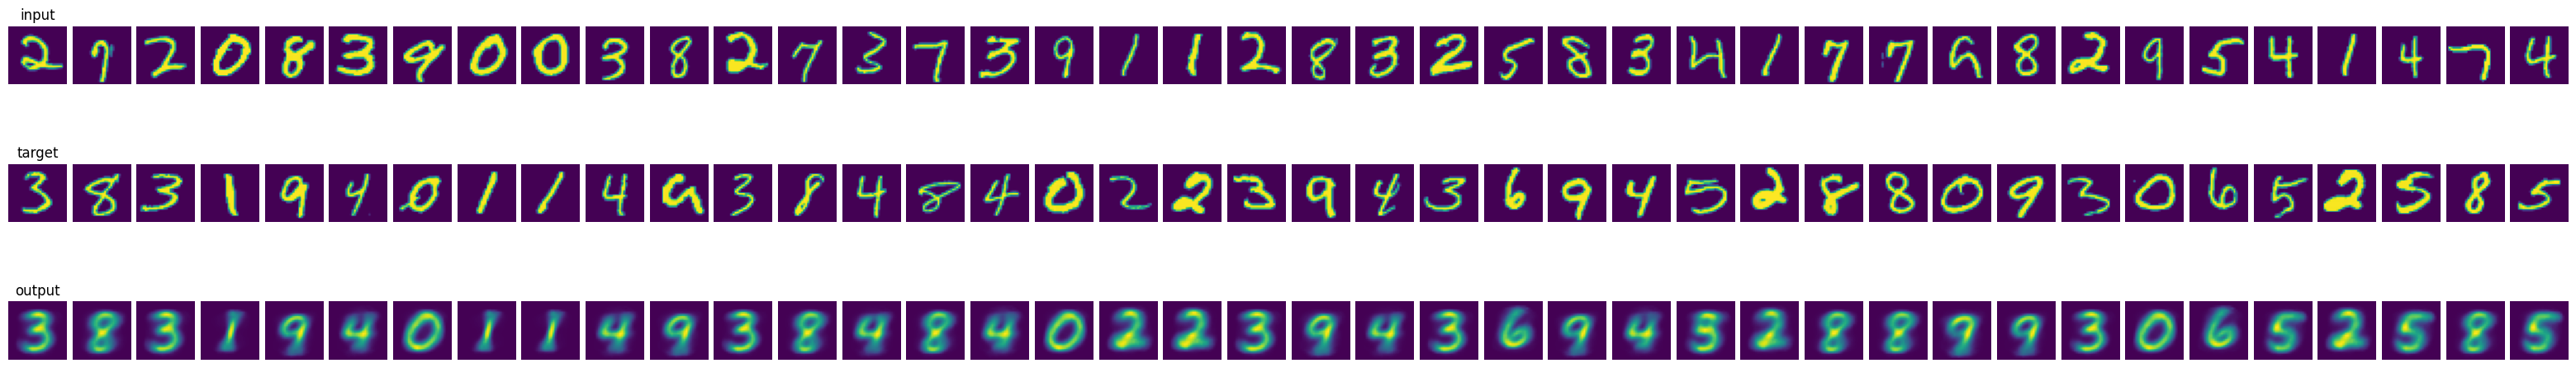

In [75]:
import matplotlib.pyplot as plt
import numpy as np

ae.eval()
test_dataset = MnistNextDigitDataset(X_test, Y_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True)

dataiter = iter(test_dataloader)
images, targets, _ = next(dataiter)

images = images.to(device).view(-1, 784)

outputs = ae(images).cpu().detach().numpy()

images = images.cpu().view(-1, 28, 28).numpy()
targets = targets.view(-1, 28, 28).numpy()
outputs = outputs.reshape(-1, 28, 28)

fig, axes = plt.subplots(3, 40, figsize=(40, 6))
for i in range(40):
    
    axes[0, i].imshow(images[i], cmap='viridis')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('input', fontsize=12)

    axes[1, i].imshow(targets[i], cmap='viridis')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('target', fontsize=12)

    axes[2, i].imshow(outputs[i], cmap='viridis')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('output', fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()